In [1]:
using Distributions, LinearAlgebra, Plots, Plots.PlotMeasures, Random, LargeMessageCollider
Random.seed!(1234);

In [2]:
# Generate a synthetic data
A = [0.8 0.1 0.1; 0.1 0.7 0.3; 0.1 0.2 0.6]
emission = [Normal(-3.5, 1.), Normal(-1., 0.5), Normal(3., 1.5)]

T = 100

z_real = []
y_real = []

push!(z_real, rand(Categorical(ones(3)./3)))
push!(y_real, rand(emission[z_real[1]]))
for t=2:T
    push!(z_real, rand(Categorical(A[:,z_real[t-1]])))
    push!(y_real, rand(emission[z_real[t]]))
end

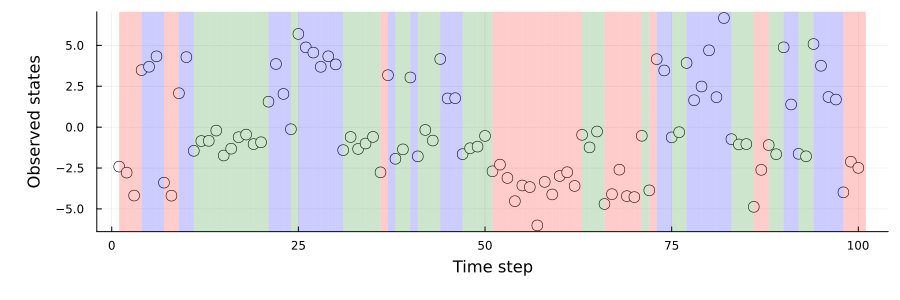

In [3]:
s1 = scatter(y_real, color=:white, markersize=6, legend=false)
colors_list = [:red, :green, :blue]

for t=1:T
    vspan!(s1,[t,t+1], color=colors_list[z_real[t]], alpha=0.2)
end

xaxis!("Time step")
yaxis!("Observed states")

plot(s1, size=(900,300), bottom_margin = 10mm, left_margin=10mm)

In [4]:
# Utility function sending message upward as categorical dist
function message_up(y)
    logp = logpdf.(emission, y) # calculate logpdfs
    p = normalize_logprob_array(logp) # probability of categories. log-sum-exp followed by normalization
    Categorical(p) # Categorical message
end
;

In [5]:
# Priors
p1 = Categorical(ones(3)./3)
pA = MatrixDirichlet([10. 1. 1.; 1. 10. 1.; 1. 1. 10.])
pm1, pm2, pm3 = Normal(mean(y_real)-std(y_real),10), Normal(mean(y_real),10), Normal(mean(y_real)+std(y_real),10)
pw1, pw2, pw3 = Gamma(1,1), Gamma(1,1), Gamma(1,1)
;

In [6]:
vmp = VMP() # a VMP instance to enable VMP message passing

# Filtering method
function filter(qA, qm, qw, T)
    forward_estimates = Array{Categorical}(undef, T)
    measure = normalmix(vmp, y_real[1], nothing, qm, qw) # VMP message
    forward_estimates[1] = p1 * measure # Update
    for t=2:T
        predict = transit(vmp,forward_estimates[t-1],qA) # Predict message structured VMP
        measure = normalmix(vmp, y_real[t], nothing, qm, qw) # VMP message
        forward_estimates[t] = predict * measure
    end
    return forward_estimates
end

# Smoothing method
function smooth(forward_estimates, qA, T)
    smooth_estimates = Array{Categorical}(undef, T)
    smooth_estimates[T] = forward_estimates[T]
    joint_dists = Array{Matrix}(undef, T-1)
    for t=T-1:-1:1
        smooth_estimates[t], joint_dists[t] = transit(vmp,forward_estimates[t],smooth_estimates[t+1],qA)
    end
    return smooth_estimates, joint_dists
end
;

In [7]:
# Inference

# Initial recognition factors
qA = pA # initial qA
qm = [pm1, pm2, pm3]
qw = [pw1, pw2, pw3]

n_its = 10 # number of iterations
FE = zeros(n_its) # store Free energy

smooth_estimates = Array{Categorical}(undef, T)
joint_dists = Array{Matrix}(undef, T-1)

# Variational updates
for i=1:n_its
    # Update q(z_{1:T})
    forward_estimates = filter(qA, qm, qw, T)
    smooth_estimates, joint_dists = smooth(forward_estimates, qA, T)
    
    # Update qA
    qA = pA
    for t=1:T-1
        message = transit(vmp,joint_dists[t],nothing)
        qA *= message
    end
    
    # update qm
    qm = [pm1, pm2, pm3]
    for t=1:T
        back_m = normalmix(vmp,y_real[t],smooth_estimates[t],nothing,qw)
        qm = collide.(qm, back_m)
    end

    # update qw
    qw = [pw1, pw2, pw3]
    for t=1:T
        back_m = normalmix(vmp,y_real[t],smooth_estimates[t],qm,nothing)
        qw = collide.(qw, back_m)
    end
    
    # Calculate Free Energy
    F=0
    F = - entropy(qA) - sum(entropy.(qm)) - sum(entropy.(qw)) - entropy(smooth_estimates[1])
    F += cross_entropy(qA,pA) + sum(cross_entropy.(qm, [pm1, pm2, pm3])) + sum(cross_entropy.(qw, [pw1, pw2, pw3]))
    F += cross_entropy(smooth_estimates[1], p1)
    for t=1:T-1
        F -= categorical_conditional_entropy(joint_dists[t])
        F += transit(joint_dists[t],qA)
        F += normalmix(y_real[t],smooth_estimates[t],qm,qw)
    end
    F += normalmix(y_real[T],smooth_estimates[T],qm,qw)
    FE[i] = F
end

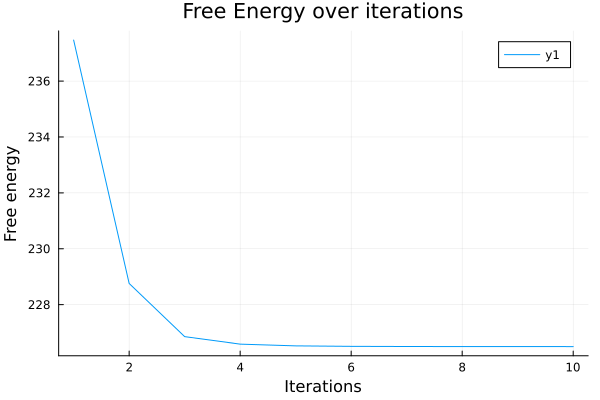

In [8]:
plot(FE, title="Free Energy over iterations", xlabel="Iterations", ylabel="Free energy")

In [9]:
qA

MatrixDirichlet(
alpha: [32.326658592315226 5.42404970413365 3.101159512375407; 3.442899270790636 35.67445170970868 9.364915899239085; 5.077467646707779 7.388619790691222 33.19977787403834]
)


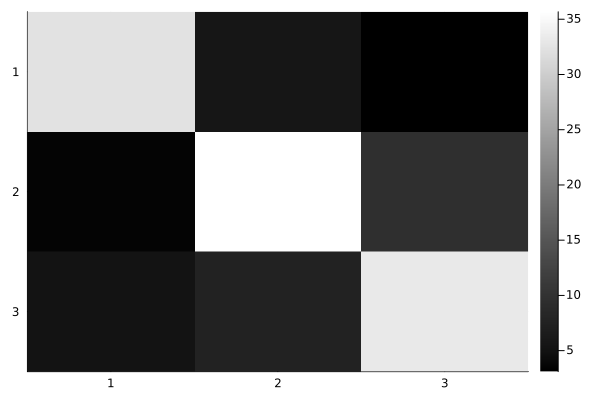

In [10]:
heatmap(qA.alpha, c=:greys, yflip=true, xticks=([1, 2, 3], ["1", "2", "3"]), yticks=([1, 2, 3], ["1", "2", "3"]))

In [11]:
qm

3-element Vector{Normal{Float64}}:
 Normal{Float64}(μ=-3.4390932857761447, σ=0.18947404813074137)
 Normal{Float64}(μ=-1.019003231301673, σ=0.09189890422001412)
 Normal{Float64}(μ=3.3734130595479, σ=0.24479087816964284)

In [12]:
qw

3-element Vector{Gamma{Float64}}:
 Gamma{Float64}(α=15.917455102698757, θ=0.058799672109544954)
 Gamma{Float64}(α=19.249601416064603, θ=0.1685472493422068)
 Gamma{Float64}(α=17.832943481236637, θ=0.02777979025876887)

In [13]:
mean.(qw)

3-element Vector{Float64}:
 0.9359411408570901
 3.244467369611538
 0.4953954296052333

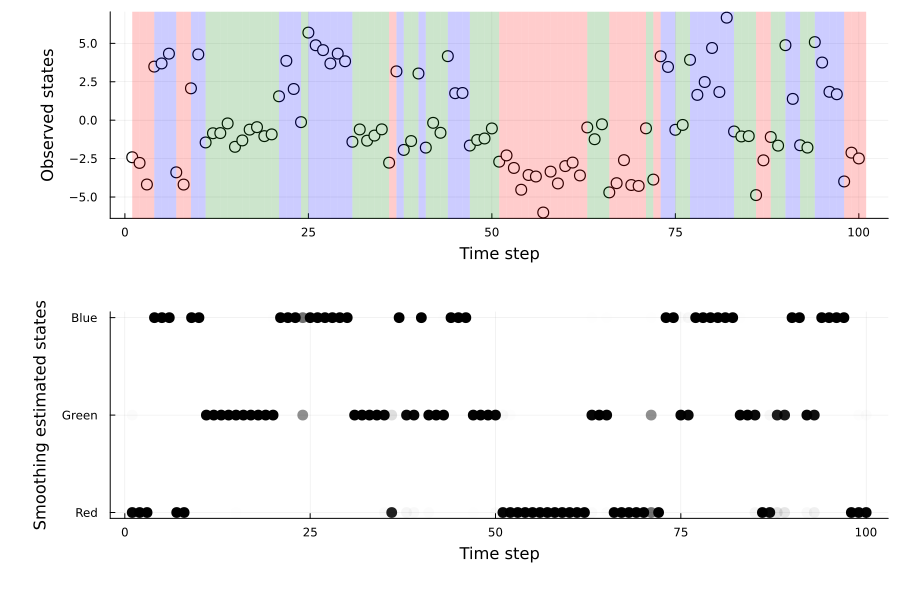

In [14]:
s1 = scatter(y_real, color=:white, markersize=6, legend=false, bottom_margin = 10mm, left_margin=10mm)
colors_list = [:red, :green, :blue]

for t=1:T
    vspan!(s1,[t,t+1], color=colors_list[z_real[t]], alpha=0.2)
end

xaxis!("Time step")
yaxis!("Observed states")

s2 = scatter((1,1),markeralpha=smooth_estimates[1].p[1], legend=false, color=:black, markersize=6)
scatter!((1,2),markeralpha=smooth_estimates[1].p[2], color=:black, markersize=6)
scatter!((1,3),markeralpha=smooth_estimates[1].p[3], color=:black, markersize=6)
for t=2:T-1
    scatter!((t,1),markeralpha=smooth_estimates[t].p[1], color=:black, markersize=6)
    scatter!((t,2),markeralpha=smooth_estimates[t].p[2], color=:black, markersize=6)
    scatter!((t,3),markeralpha=smooth_estimates[t].p[3], color=:black, markersize=6)
end
scatter!((T,1),markeralpha=smooth_estimates[T].p[1], color=:black, markersize=6)
scatter!((T,2),markeralpha=smooth_estimates[T].p[2], color=:black, markersize=6)
scatter!((T,3),markeralpha=smooth_estimates[T].p[3], color=:black, markersize=6, bottom_margin = 10mm, left_margin=10mm)

xaxis!("Time step")
yaxis!("Smoothing estimated states")
yticks!([1,2,3],["Red", "Green", "Blue"])

plot(s1, s2, layout = (2, 1), size=(900,600))